In [1]:
# Built-in modules
import numpy as np
import math
from scipy.linalg import expm

# Imports from Qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import GroverOperator, MCMT, ZGate, QFT
from qiskit.visualization import plot_distribution
from qiskit.quantum_info import Operator
from qiskit.circuit.library import UnitaryGate


# Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

[[1.-2.58022041e-17j 0.+0.00000000e+00j]
 [0.+0.00000000e+00j 1.+2.34195863e-17j]]


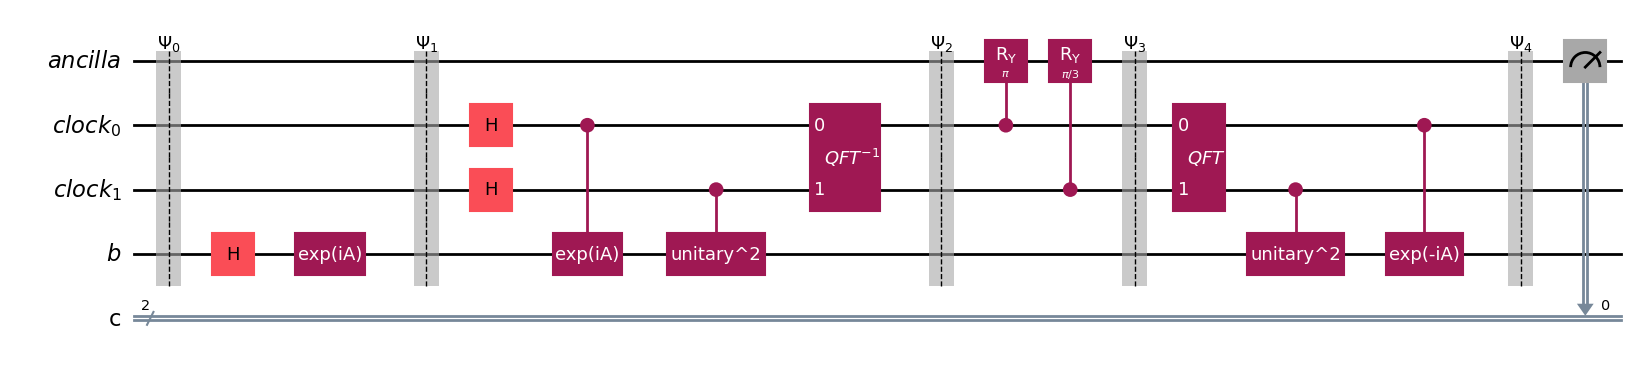

In [2]:
I = 1
T = 2
S = 1

# Define the matrix A
A = np.array([[1/2, 0], [0, 1]])

# Compute the exponential of iA
iA = 1j * A
exp_iA = expm(iA)
exp_iAh = expm(-iA)
print(exp_iA*exp_iAh)

# Create a unitary gate from the matrix
unitary_gate = UnitaryGate(exp_iA, label='exp(iA)')
inverse_unitary_gate = UnitaryGate(exp_iAh, label='exp(-iA)')

qfth = QFT(num_qubits=2, inverse=True, name='$QFT^{-1}$').to_gate()
qft = QFT(num_qubits=2, inverse=False, name='$QFT$').to_gate()

b = QuantumRegister(I, name='b')
clock = QuantumRegister(T, name='clock')
ancilla = QuantumRegister(S, name='ancilla')
measurement = ClassicalRegister(2, name='c')
hhl = QuantumCircuit(ancilla, clock, b, measurement)
hhl.barrier(label='$\\Psi_0$')

hhl.h(b[0])
hhl.append(unitary_gate, [b[0]])

hhl.barrier(label='$\\Psi_1$')

hhl.h(clock)

hhl.append(unitary_gate.control(1), [clock[0], b[0]])
hhl.append(unitary_gate.power(2).control(1), [clock[1], b[0]])



hhl.append(qfth, clock)


hhl.barrier(label='$\\Psi_2$')

hhl.cry(np.pi, clock[0], ancilla)
hhl.cry(np.pi/3, clock[1], ancilla)

hhl.barrier(label='$\\Psi_3$')


hhl.append(qft, clock)
hhl.append(inverse_unitary_gate.power(2).control(1), [clock[1], b[0]])
hhl.append(inverse_unitary_gate.control(1), [clock[0], b[0]])

hhl.barrier(label='$\\Psi_4$')

hhl.measure(ancilla[0], measurement[0])


hhl.draw(output="mpl", style="iqp")


In [54]:
# Use the following code instead if you want to run on a simulator:

from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp

observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels]

backend = FakeAlmadenV2()
estimator = Estimator(backend)
 
# Convert to an ISA circuit and layout-mapped observables.
 
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(hhl)
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]
 
job = estimator.run([(isa_circuit, mapped_observables)])
result = job.result()
 
# This is the result of the entire submission.  You submitted one Pub,
# so this contains one inner result (and some metadata of its own).
 
job_result = job.result()
 
# This is the result from our single pub, which had five observables,
# so contains information on all five.
 
pub_result = job.result()[0]

QiskitError: 'Number of qargs does not match (4 != 2)'